## This notebook will help you train a vanilla Point-Cloud AE with the basic architecture we used in our paper.
    (it assumes latent_3d_points is in the PYTHONPATH and the structural losses have been compiled)

In [1]:
import os.path as osp

import sys
sys.path.append('/home/jcollins')

from latent_3d_points.src.ae_templates import mlp_architecture_ala_iclr_18, default_train_params
from latent_3d_points.src.autoencoder import Configuration as Conf
from latent_3d_points.src.point_net_ae import PointNetAutoEncoder

from latent_3d_points.src.in_out import snc_category_to_synth_id, create_dir, PointCloudDataSet, \
                                        load_all_point_clouds_under_folder

from latent_3d_points.src.tf_utils import reset_tf_graph
from latent_3d_points.src.general_utils import plot_3d_point_cloud

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Define Basic Parameters

In [6]:
top_out_dir = '../data/'          # Use to save Neural-Net check-points etc.
top_in_dir = '../data/shape_net_core_uniform_samples_2048/' # Top-dir of where point-clouds are stored.

experiment_name = 'single_class_ae'
n_pc_points = 1000                # Number of points per model.
bneck_size = 128                  # Bottleneck-AE size
ae_loss = 'emd'                   # Loss to optimize: 'emd' or 'chamfer'
class_name = raw_input('Give me the class name (e.g. "chair"): ').lower()

Give me the class name (e.g. "chair"): chair


Load Point-Clouds

In [7]:
syn_id = snc_category_to_synth_id()[class_name]
class_dir = osp.join(top_in_dir , syn_id)
all_pc_data = load_all_point_clouds_under_folder(class_dir, n_threads=8, file_ending='.ply', verbose=True)

6778 pclouds were loaded. They belong in 1 shape-classes.


In [8]:
import pandas as pd
numjets = 100000
outstore = pd.HDFStore("/data1/users/jcollins/Heidelberg_sample/train_points.h5")
rawdata = outstore.select("points",stop=numjets).values
rawdata = rawdata.reshape(numjets,1000,2)
all_pc_data = PointCloudDataSet(rawdata)

Load default training parameters (some of which are listed beloq). For more details please print the configuration object.

    'batch_size': 50   
    
    'denoising': False     (# by default AE is not denoising)

    'learning_rate': 0.0005

    'z_rotate': False      (# randomly rotate models of each batch)
    
    'loss_display_step': 1 (# display loss at end of these many epochs)
    'saver_step': 10       (# over how many epochs to save neural-network)

In [9]:
train_params = default_train_params()

In [10]:
encoder, decoder, enc_args, dec_args = mlp_architecture_ala_iclr_18(n_pc_points, bneck_size)
train_dir = create_dir(osp.join(top_out_dir, experiment_name))

In [11]:
train_params['batch_size'] = 200

In [12]:
train_params['training_epochs']

500

In [13]:
conf = Conf(n_input = [n_pc_points, 2],
            loss = ae_loss,
            training_epochs = train_params['training_epochs'],
            batch_size = train_params['batch_size'],
            denoising = train_params['denoising'],
            learning_rate = train_params['learning_rate'],
            train_dir = train_dir,
            loss_display_step = train_params['loss_display_step'],
            saver_step = train_params['saver_step'],
            z_rotate = train_params['z_rotate'],
            encoder = encoder,
            decoder = decoder,
            encoder_args = enc_args,
            decoder_args = dec_args
           )
conf.experiment_name = experiment_name
conf.held_out_step = 5   # How often to evaluate/print out loss on 
                         # held_out data (if they are provided in ae.train() ).
conf.save(osp.join(train_dir, 'configuration'))

If you ran the above lines, you can reload a saved model like this:

In [15]:
load_pre_trained_ae = True
restore_epoch = 100
if load_pre_trained_ae:
    conf = Conf.load(train_dir + '/configuration')
    reset_tf_graph()
    ae = PointNetAutoEncoder(conf.experiment_name, conf)
    ae.restore_model(conf.train_dir, epoch=restore_epoch)

Building Encoder
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
encoder_conv_layer_0 conv params =  192 bnorm params =  128
Tensor("single_class_ae_2/Relu:0", shape=(?, 1000, 64), dtype=float32)
output size: 64000 

encoder_conv_layer_1 conv params =  8320 bnorm params =  256
Tensor("single_class_ae_2/Relu_1:0", shape=(?, 1000, 128), dtype=float32)
output size: 128000 

encoder_conv_layer_2 conv params =  16512 bnorm params =  256
Tensor("single_class_ae_2/Relu_2:0", shape=(?, 1000, 128), dtype=float32)
output size: 128000 

encoder_conv_layer_3 conv params =  33024 bnorm params =  512
Tensor("single_class_ae_2/Relu_3:0", shape=(?, 1000, 256), dtype=float32)
output size: 256000 

encoder_conv_layer_4 conv params =  32896 bnorm params =  256
Tensor("single_class_ae_2/Relu_4:0", shape=(?, 1000, 128), dtype=float32)
output size: 128000 

Tensor("single_class_ae_2/Max:0", shape=(?, 128), dtype=float32)
Building 

Build AE Model.

In [12]:
reset_tf_graph()
ae = PointNetAutoEncoder(conf.experiment_name, conf)

Building Encoder
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
encoder_conv_layer_0 conv params =  192 bnorm params =  128
Tensor("single_class_ae_2/Relu:0", shape=(?, 1000, 64), dtype=float32)
output size: 64000 

encoder_conv_layer_1 conv params =  8320 bnorm params =  256
Tensor("single_class_ae_2/Relu_1:0", shape=(?, 1000, 128), dtype=float32)
output size: 128000 

encoder_conv_layer_2 conv params =  16512 bnorm params =  256
Tensor("single_class_ae_2/Relu_2:0", shape=(?, 1000, 128), dtype=float32)
output size: 128000 

encoder_conv_layer_3 conv params =  33024 bnorm params =  512
Tensor("single_class_ae_2/Relu_3:0", shape=(?, 1000, 256), dtype=float32)
output size: 256000 

encoder_conv_layer_4 conv params =  32896 bnorm params =  256
Tensor("single_class_ae_2/Relu_4:0", shape=(?, 1000, 128), dtype=float32)
output size: 128000 

Tensor("single_class_ae_2/Max:0", shape=(?, 128), dtype=float32)
Building 

Train the AE (save output to train_stats.txt) 

In [13]:
buf_size = 1 # Make 'training_stats' file to flush each output line regarding training.
fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)
train_stats = ae.train(all_pc_data, conf, log_file=fout)
fout.close()

('Epoch:', '0001', 'training time (minutes)=', '1.5886', 'loss=', '0.175911824')
INFO:tensorflow:../data/single_class_ae/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.
('Epoch:', '0002', 'training time (minutes)=', '1.6165', 'loss=', '0.153389365')
('Epoch:', '0003', 'training time (minutes)=', '1.6338', 'loss=', '0.147815618')
('Epoch:', '0004', 'training time (minutes)=', '1.6282', 'loss=', '0.144953111')
('Epoch:', '0005', 'training time (minutes)=', '1.6294', 'loss=', '0.142494342')
('Epoch:', '0006', 'training time (minutes)=', '1.6311', 'loss=', '0.140977526')
('Epoch:', '0007', 'training time (minutes)=', '1.6274', 'loss=', '0.139358955')
('Epoch:', '0008', 'training time (minutes)=', '1.6301', 'loss=', '0.138330758')
('Epoch:', '0009', 'training time (minutes)=', '1.6304', 'loss=', '0.137310831')
('Epoch:', '0010', 'training time (minutes)=', '1.6284', 'loss=', '0.136391488')
INFO:tensorflow:../data/single_class_ae/models.ckpt-10 is not in all_model_che

('Epoch:', '0090', 'training time (minutes)=', '1.6471', 'loss=', '0.119798615')
INFO:tensorflow:../data/single_class_ae/models.ckpt-90 is not in all_model_checkpoint_paths. Manually adding it.
('Epoch:', '0091', 'training time (minutes)=', '1.6445', 'loss=', '0.119808153')
('Epoch:', '0092', 'training time (minutes)=', '1.6464', 'loss=', '0.119644103')
('Epoch:', '0093', 'training time (minutes)=', '1.6457', 'loss=', '0.119688168')
('Epoch:', '0094', 'training time (minutes)=', '1.6453', 'loss=', '0.119601791')
('Epoch:', '0095', 'training time (minutes)=', '1.6465', 'loss=', '0.119578556')
('Epoch:', '0096', 'training time (minutes)=', '1.6437', 'loss=', '0.119527400')
('Epoch:', '0097', 'training time (minutes)=', '1.6427', 'loss=', '0.119530163')
('Epoch:', '0098', 'training time (minutes)=', '1.6445', 'loss=', '0.119354915')
('Epoch:', '0099', 'training time (minutes)=', '1.6391', 'loss=', '0.119319114')
('Epoch:', '0100', 'training time (minutes)=', '1.6435', 'loss=', '0.11922686

KeyboardInterrupt: 

In [16]:
buf_size = 1 # Make 'training_stats' file to flush each output line regarding training.
fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)

Get a batch of reconstuctions and their latent-codes.

In [17]:
feed_pc, feed_model_names, _ = all_pc_data.next_batch(10)
reconstructions = ae.reconstruct(feed_pc)[0]
latent_codes = ae.transform(feed_pc)

Use any plotting mechanism such as matplotlib to visualize the results.

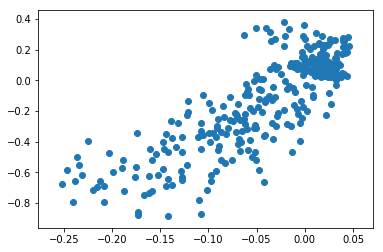

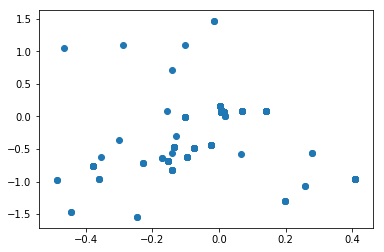

In [26]:
import matplotlib.pyplot as plt
i = 2
plt.scatter(reconstructions[i][:, 0],reconstructions[i][:, 1])
plt.show()
plt.scatter(feed_pc[i][:, 0],feed_pc[i][:, 1])
plt.show(    lim=1
    plt.figure(figsize=[5,5])
    plt.hist2d(jet[:,2],jet[:,3],weights = jet[:,0],range=[[-lim,lim],[-lim,lim]],bins=30)
    plt.show())

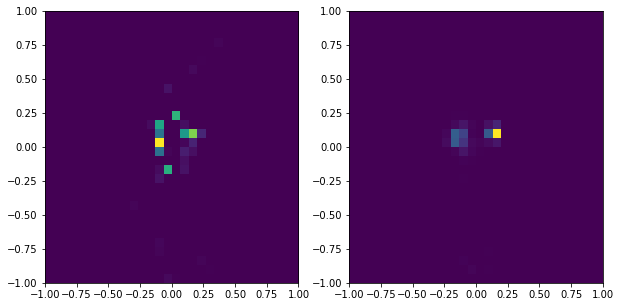

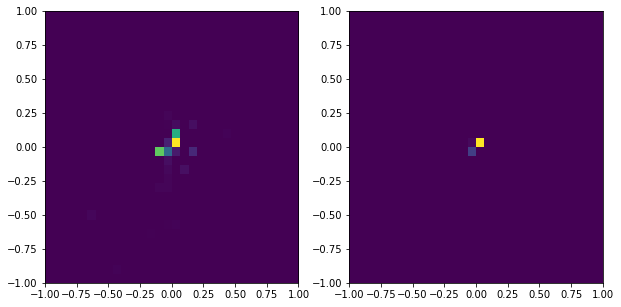

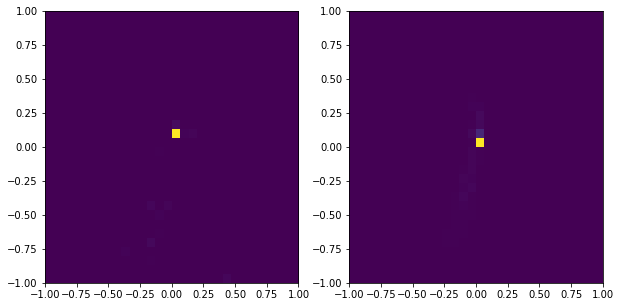

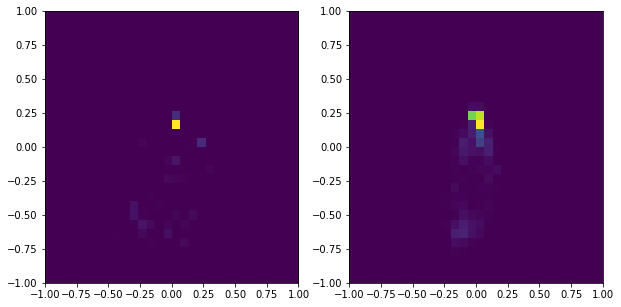

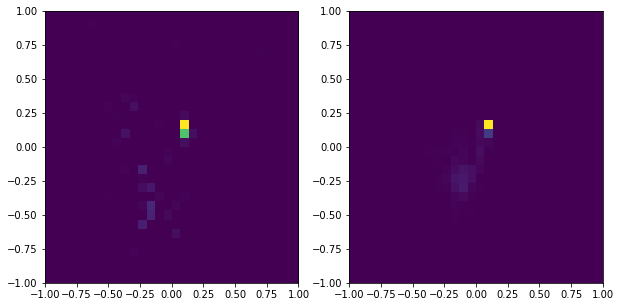

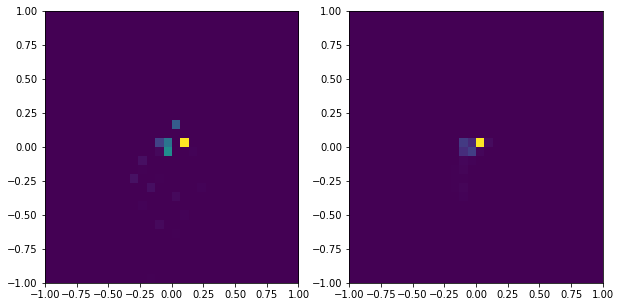

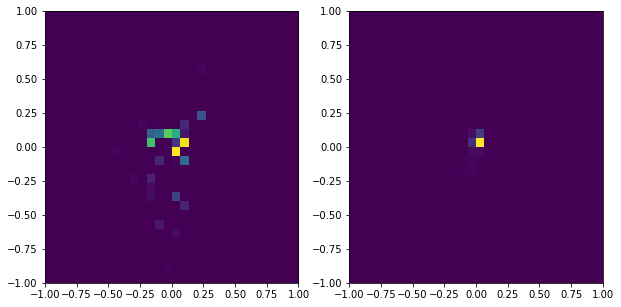

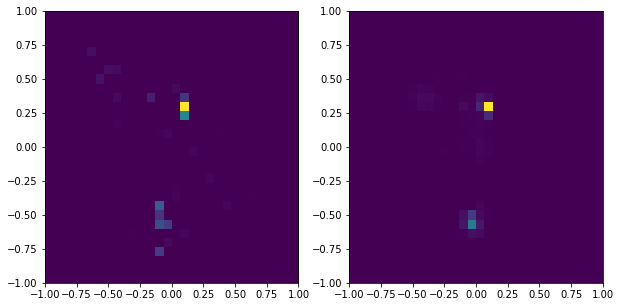

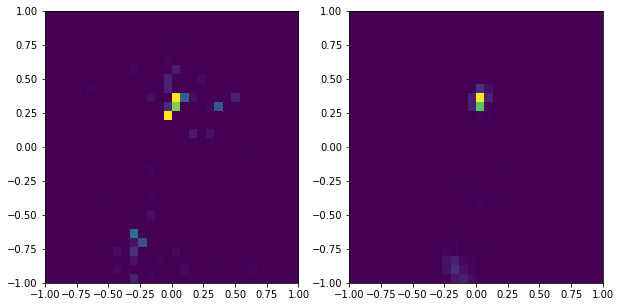

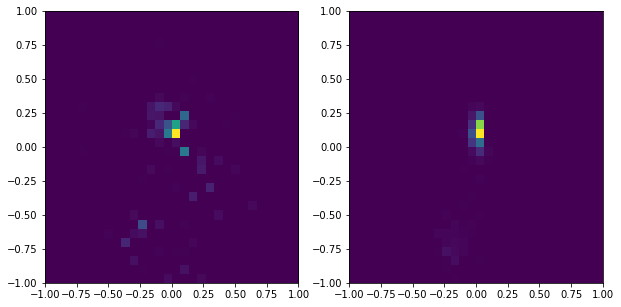

In [35]:
lim=1


for i in range(10):
    fig, ax = plt.subplots(1, 2,figsize=[10,5])
    ax[0].hist2d(feed_pc[i][:,0],feed_pc[i][:,1],range=[[-lim,lim],[-lim,lim]],bins=30)
    ax[1].hist2d(reconstructions[i][:,0],reconstructions[i][:,1],range=[[-lim,lim],[-lim,lim]],bins=30)
    plt.show()

In [19]:
reconstructions[i][:, 0]

array([ 1.98116172e-02, -9.80909318e-02,  1.97917651e-02, -1.08057469e-01,
        1.82144586e-02, -2.91212648e-03,  8.61228351e-03,  1.83195081e-02,
        2.42192168e-02,  2.91672256e-03,  1.93968453e-02,  3.03523894e-02,
        1.89749710e-02,  2.73991711e-02,  3.30384709e-02, -2.12018877e-01,
        2.02254634e-02,  1.80993378e-02,  1.87749024e-02,  2.05652807e-02,
        2.05107220e-02,  2.18294803e-02,  2.20789425e-02,  1.87797919e-02,
       -5.89506775e-02,  4.32057567e-02,  2.03222465e-02,  2.94170640e-02,
        5.38245961e-03,  1.99493673e-02, -1.11112341e-01,  1.86225343e-02,
        1.13107050e-02,  2.00300086e-02,  1.51581783e-02,  2.11701673e-02,
        2.10208967e-02,  1.79020036e-02,  7.02299364e-03, -2.95110606e-02,
        1.88258030e-02,  1.91394314e-02,  1.61528550e-02,  1.96573846e-02,
        2.14328505e-02,  1.95273701e-02,  2.08977107e-02,  2.13412084e-02,
       -5.76115213e-02,  2.50919722e-02,  1.99367851e-02,  2.89640836e-02,
       -4.79152240e-03,  